# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 05.10.2023

Мягкий дедлайн: 23:59MSK 18.10.2023

Жесткий дедлайн: 23:59MSK 22.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: очень мало, не знаю.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [460]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)


Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [461]:
df_start = pd.read_csv('train.csv')


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [463]:
df = df_start.drop(['dropoff_datetime'], axis = 1)
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

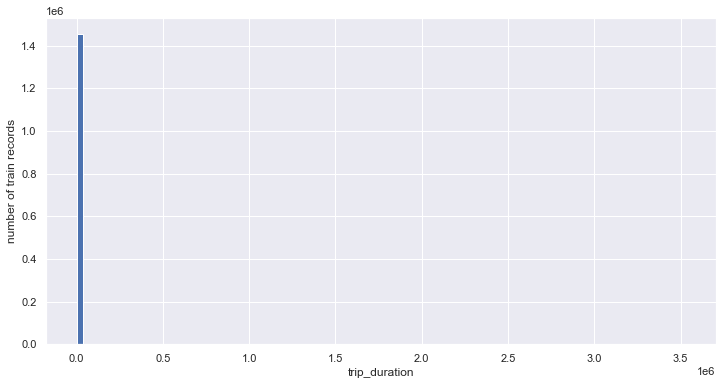

In [464]:
plt.figure(figsize=(12,6))
plt.hist(df['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений? - Есть огромные выбросы, можно чекнуть максимальное значение, оно равно 3526282


В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?  - Хотели сгладить выбросы

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: В rmsle в выражении под знаком суммы  $$(\log{(y_i + 1)} - \log{(a(x_i) + 1)}$$ можем заметить, что в обеих скобках добавляется одна и та же константа, а значит разность итоговая не изменится. Логарифмирование и извлечение корня - это монотонные линейные преобразования, поэтому оптимизация происходит с точностью до константы. 

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [466]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])
df = df.drop(['trip_duration'], axis=1)


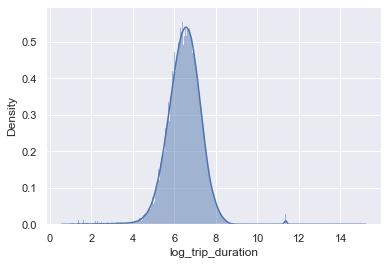

In [467]:
sns_plot = sns.histplot(df['log_trip_duration'], kde=True, #распределение стало похоже на нормальное
    stat="density", kde_kws=dict(cut=3))
fig = sns_plot.get_figure()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [468]:
def rmsle(log1p_y_true, log1p_y_pred):
    squared_errors = ((log1p_y_true - log1p_y_pred)**2)
    mean_squared_errors = np.mean(squared_errors)
    rmsle = np.sqrt(mean_squared_errors)
    return rmsle
log1p_y_mean= np.mean(df['log_trip_duration'])
rmsle_best_const = rmsle(df['log_trip_duration'], log1p_y_mean)
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365412156


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [469]:
dates = df['pickup_datetime'].dt.date.to_frame().sort_index(ascending=True)
amount = dates['pickup_datetime'].value_counts().to_frame().reset_index()
amount.columns = ['date', 'count']
amount = amount.sort_values(by='count')


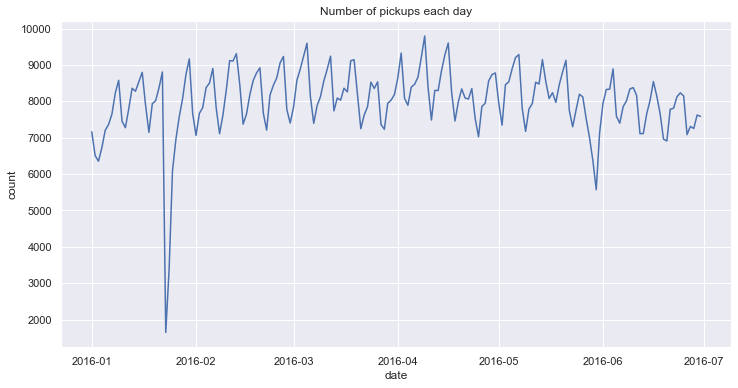

In [470]:
plt.figure(figsize=(12,6)) #countplot выводит пустоту
sns.lineplot(data=amount, x='date', y='count')
plt.title('Number of pickups each day')
plt.show()


**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [471]:
amount = amount.sort_values(by = 'count')
amount[:15]
#первый период с 23-24 января: непогода на северо-востоке сша, снежная буря, людяс советовали не выходить из дома
# второй период 29-30 мая - огонь на севере Манхэттена, в Бруклине, в Восточном Гарлеме и в районе Куинс + 29 мая был сбой в аэропорту Кеннеди
# было задержано очень много рейсов, люди ждали в аэропорту, а те, кто должен был улететь в эти дни, но еще не доехал до аэропорта, узнав о задержке
# не пользовались услугами такси, чтоб туда доехать

,date,count
181,2016-01-23,1648
180,2016-01-24,3383
179,2016-05-30,5570
178,2016-01-25,6084
177,2016-01-03,6353
176,2016-05-29,6372
175,2016-01-02,6512
174,2016-01-04,6725
173,2016-06-20,6910
172,2016-01-26,6941


In [472]:
dates['day_of_week'] =df['pickup_datetime'].dt.day_name ()
dates['hour']=df['pickup_datetime'].dt.hour



In [473]:
gr_df = dates.groupby(['day_of_week', 'hour']).agg('count')
gr_df=gr_df.rename(columns = {"pickup_datetime":"count"})
gr_df

count
day_of_week hour       
Friday      0      8779
            1      5804
            2      3949
            3      2924
            4      2313
...                 ...
Wednesday   19    13693
            20    13183
            21    13438
            22    12407
            23     9735

[168 rows x 1 columns]

<Figure size 864x576 with 0 Axes>

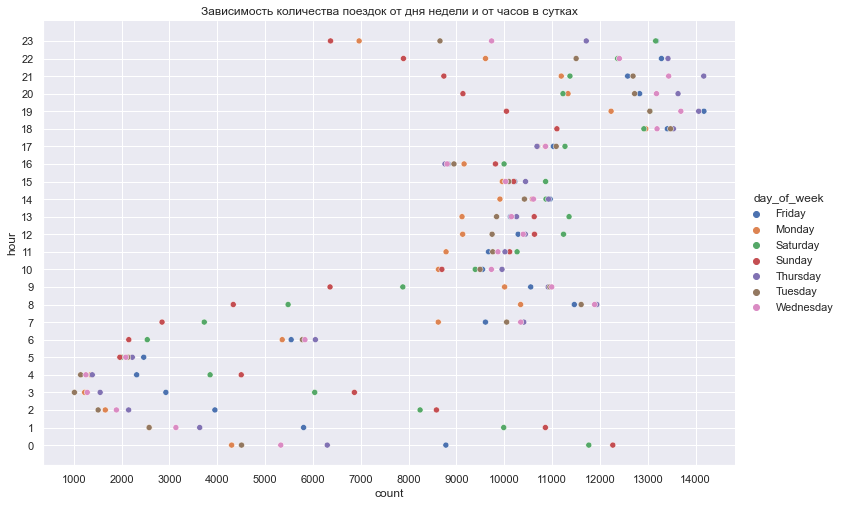

In [474]:
plt.figure(figsize=(12,8))
sns.relplot(x='count', y='hour', hue='day_of_week', kind='scatter', data=gr_df,  height=7, aspect=1.5)
plt.xticks(np.arange(1000,15000,1000))
plt.yticks(np.arange(0,24))
plt.title('Зависимость количества поездок от дня недели и от часов в сутках');

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [423]:
dates_months = pd.DataFrame()
dates_months['hour'] = df['pickup_datetime'].dt.hour
dates_months['month'] = df['pickup_datetime'].dt.month
gr_df_months = dates_months.groupby(['month', 'hour'])['month'].count().to_frame()
gr_df_months=gr_df_months.rename(columns = {"month":"count"})
dates_months.groupby(['month', 'hour'])['month'].count()
gr_df_months

count
month hour       
1     0      8330
      1      6400
      2      4830
      3      3574
      4      2612
...           ...
6     19    14187
      20    12799
      21    13740
      22    13391
      23    11899

[144 rows x 1 columns]

<Figure size 864x576 with 0 Axes>

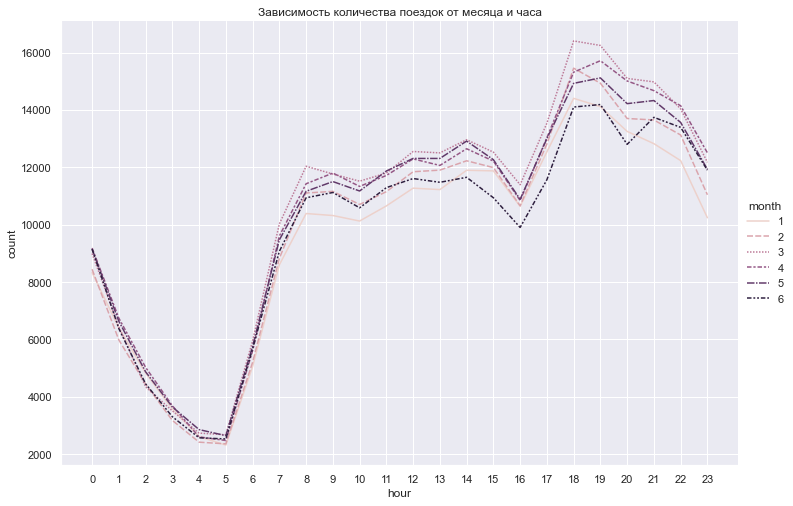

In [475]:
plt.figure(figsize=(12,8))
sns.relplot(x='hour', y='count', hue='month', kind='line', data=gr_df_months, height=7, aspect=1.5, style="month")
plt.xticks(np.arange(0,24))
plt.title('Зависимость количества поездок от месяца и часа');

<Figure size 864x576 with 0 Axes>

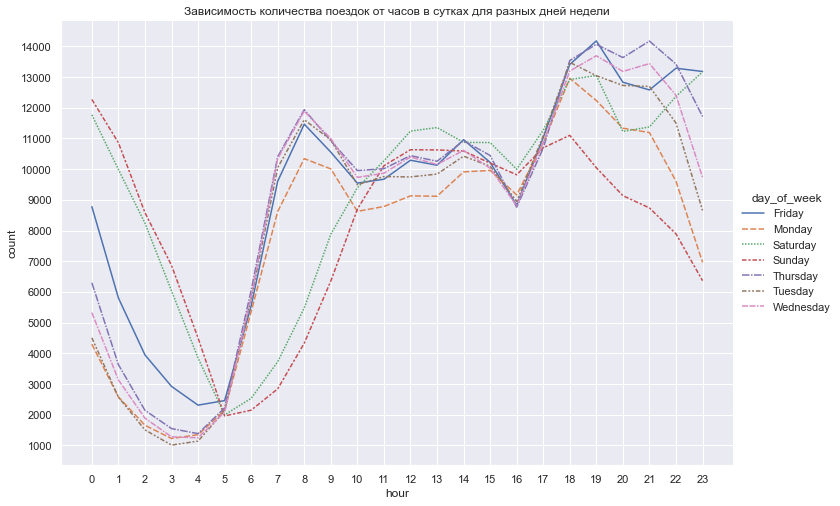

In [476]:
plt.figure(figsize=(12,8))
sns.relplot(x='hour', y='count', hue='day_of_week', kind='line', data=gr_df,  height=7, aspect=1.5, style="day_of_week")

plt.yticks(np.arange(1000,15000,1000))
plt.xticks(np.arange(0,24))
plt.title('Зависимость количества поездок от часов в сутках для разных дней недели');

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано? 

В июле и январе в среднем по часам меньше всего поездок (рождественские и новогодние праздники, а летом потому что тепло, люди меньше пользуются услугами такси). Логично, что ночью с 00:00 до 6:00 меньше всего поездок, больше всего в 6-7 вечера, когда люди возвращаются с работы. В воскресенье ночная жизнь кипит, число поездок больше, чем в другие дни недели, а вот к концу дня поездок в среднем меньше, чем в другие дни.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

C:\Users\murad\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


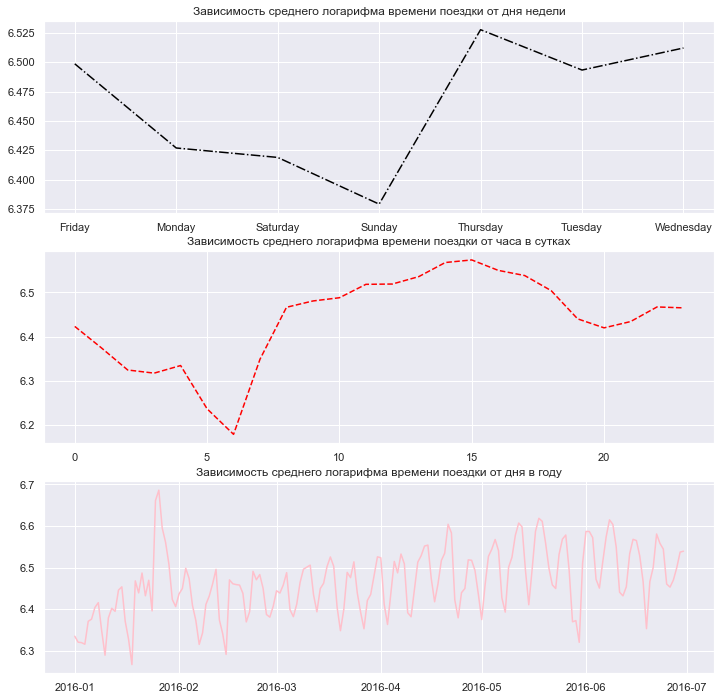

In [477]:
from sklearn.model_selection import train_test_split
y = df["log_trip_duration"]
X = df.drop(['log_trip_duration'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
x_train.loc[:,'log_trip_duration'] = y_train

mean_for_weekday = (x_train.groupby(x_train['pickup_datetime'].dt.day_name())['log_trip_duration'].
                    mean().to_frame().reset_index().rename(columns={'pickup_datetime': 'weekday'}))
mean_for_hour = (x_train.groupby(x_train['pickup_datetime'].dt.hour)['log_trip_duration'].
                 mean().to_frame().reset_index().rename(columns={'pickup_datetime': 'hour'}))
mean_for_day = (x_train.groupby(x_train['pickup_datetime'].dt.date)['log_trip_duration'].
                mean().to_frame().reset_index().rename(columns={'pickup_datetime': 'day'}))

fig, axs = plt.subplots(nrows= 3 , ncols= 1, figsize=(12,12) )
axs[0].plot(mean_for_weekday['weekday'],mean_for_weekday['log_trip_duration'], '-.', c='black')
axs[0].set_title('Зависимость среднего логарифма времени поездки от дня недели')
axs[1].plot(mean_for_hour['hour'], mean_for_hour['log_trip_duration'], '--', c='red')
axs[1].set_title('Зависимость среднего логарифма времени поездки от часа в сутках')
axs[2].plot(mean_for_day['day'], mean_for_day['log_trip_duration'], '-', c='pink')
axs[2].set_title('Зависимость среднего логарифма времени поездки от дня в году');
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

График зависимости таргета от часа в сутках похож на тот, что был выше, от дня недели - нет.  Наверное, из-за того, что в будние рабочие дни образуются пробки и продолжительность поездок больше (и ось абсцисс принимает другое значение), чем в выходные (особенно в середине недели), а график зависимости длительности времени поездок от часа похож, потому что выше у нас ось абсцисс тоже принимала значение часа в сутках и глубокой ночью меньше пробок, соответственно, длительность поездок тоже меньше, чем в рабочее время суток.

Во время январских событий среднее время поездки было очень высоким, полагаю, из-за пробок и просто потому что тяжело было проехать по снежным улицам. Во время майских событий среднее время поездок наоборот упало (мб меньше людей заказывали такси, меньше пробок, люди быстрее доезжали )).

От номера дня в году видна периодичная зависимость (кроме некоторых периодов, о которых речь шла выше) - из-за того что в будние дни среднее время в дороге выше, чем выходные, что повторяется от недели к неделе.


Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [478]:
df['weekday'] = df['pickup_datetime'].dt.day_name ()
df['month'] = df['pickup_datetime'].dt.month
df['hour'] = df['pickup_datetime'].dt.hour

jan_dates = [pd.to_datetime('2016-01-23').date(), pd.to_datetime('2016-01-24').date()]
df['jan_incidents'] = df['pickup_datetime'].dt.date.isin(jan_dates).astype(int)

may_dates = [pd.to_datetime('2016-05-29').date(), pd.to_datetime('2016-05-30').date()]
df['may_incidents'] = df['pickup_datetime'].dt.date.isin(may_dates).astype(int)
df['day_of_the_year'] = df['pickup_datetime'].dt.dayofyear



Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

Как будто бы все признаки стоит рассматривать как категориальные, эти признаки не описываются числовыми значениями, они просто задают порядок (который каждый может задать по-своему, если б был в этом смысл).

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [479]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
df[['month','hour','jan_incidents', 'may_incidents','day_of_the_year']] = df[['month','hour','jan_incidents', 'may_incidents','day_of_the_year']].astype('object')
y = df["log_trip_duration"]
X = df.drop(['log_trip_duration','id'], axis=1) #лишние ненужные айди, если оставить, модель переобучается под трейн
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

numeric_features = ['vendor_id', "passenger_count"] #не масштабируем координаты 
categorical = list(x_train.dtypes[x_train.dtypes == "object"].index)
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
print("Test rmsle = %.4f" % rmsle(y_test, y_pred))
print("Train rmsle = %.4f" % rmsle(y_train, y_train_pred))

Test rmsle = 0.7853
Train rmsle = 0.7882


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [480]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [581]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

Больше всего точек в районе Манхэттена, там будут пробки, а значит время поездки увеличено

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [482]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


df.loc[:, 'distance_haversine'] = haversine_array(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)


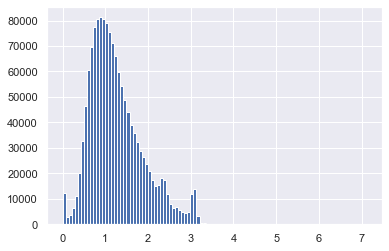

In [484]:
plt.hist(np.log1p(df.distance_haversine), bins=100)
plt.show()

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [488]:
 df['log_haversine']=np.log1p(df['distance_haversine'])


Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [486]:
your_df = df
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['distance_haversine'].corr(your_df['log_trip_duration'])

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

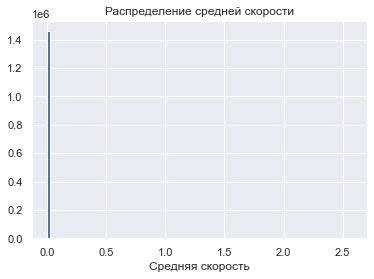

In [489]:
df['trip_duration'] = np.expm1(df['log_trip_duration'])
df['speed']= (df['distance_haversine']/df['trip_duration'])
plt.hist((df.speed), bins = 100)
plt.title('Распределение средней скорости')
plt.xlabel('Средняя скорость')
plt.show()



Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

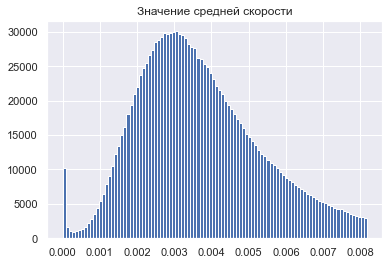

In [491]:
quantile_val = df['speed'].quantile(0.95)
filtered_speed_values = df[df['speed']<quantile_val]
plt.hist((filtered_speed_values.speed), bins = 100)
plt.title("Значение средней скорости")
plt.show()


Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [492]:
med_speed =  df.groupby(['weekday', 'hour'])['speed'].median().to_frame()
df_med = med_speed.unstack(level='weekday')
df_med

speed                                                            
weekday    Friday    Monday  Saturday    Sunday  Thursday   Tuesday Wednesday
hour                                                                         
0        0.004447  0.005585  0.003919  0.003973  0.004806  0.005239  0.004968
1        0.004816  0.005620  0.004312  0.004275  0.005304  0.005566  0.005402
2        0.005031  0.005757  0.004524  0.004598  0.005524  0.005672  0.005584
3        0.005272  0.005738  0.004853  0.004887  0.005849  0.006042  0.005774
4        0.005825  0.006621  0.005299  0.005195  0.006298  0.006446  0.006337
5        0.006303  0.006548  0.006334  0.006136  0.006167  0.006335  0.006283
6        0.005211  0.005247  0.006131  0.006620  0.005106  0.005020  0.005075
7        0.003850  0.004023  0.005435  0.005934  0.003754  0.003745  0.003742
8        0.002998  0.003190  0.004748  0.005163  0.002888  0.002886  0.002918
9        0.002742  0.002997  0.004262  0.004818  0.002694  0.002668  0.002655
10       0.002758  0.003039  0.004018  0.004475  0.002665  0.002625  0.002635
11       0.002745  0.003107  0.003703  0.004076  0.002607  0.002590  0.002545
12       0.002801  0.003076  0.003508  0.003844  0.002569  0.002617  0.002504
13       0.003039  0.003189  0.003367  0.003711  0.002720  0.002708  0.002612
14       0.002936  0.003172  0.003369  0.003632  0.002693  0.002745  0.002649
15       0.002872  0.003200  0.003349  0.003658  0.002715  0.002769  0.002672
16       0.003046  0.003328  0.003412  0.003680  0.002898  0.002974  0.002911
17       0.003081  0.003343  0.003360  0.003726  0.002940  0.003035  0.002893
18       0.003108  0.003371  0.003242  0.003725  0.002936  0.003054  0.002954
19       0.003214  0.003805  0.003123  0.003906  0.003218  0.003458  0.003279
20       0.003521  0.004247  0.003366  0.004239  0.003628  0.003910  0.003761
21       0.003606  0.004413  0.003549  0.004515  0.003769  0.004107  0.004003
22       0.003629  0.004531  0.003536  0.004788  0.003875  0.004323  0.004131
23       0.003719  0.004978  0.003708  0.005143  0.004162  0.004637  0.004459

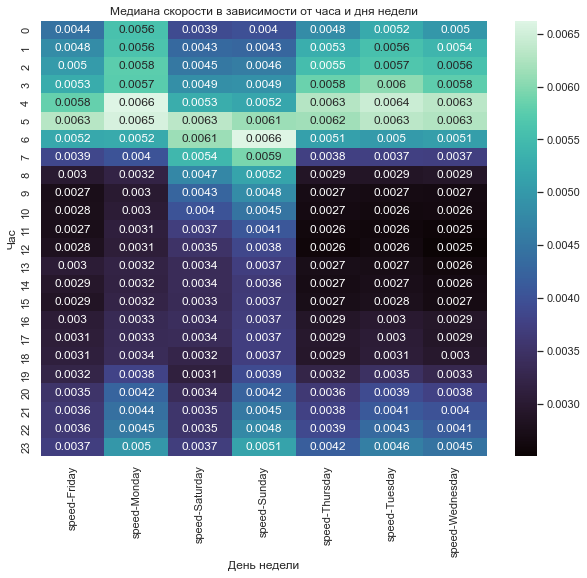

In [493]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_med, cmap='mako', annot=True) 
plt.title('Медиана скорости в зависимости от часа и дня недели')
plt.ylabel('Час') 
plt.xlabel('День недели');



Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения? - Это значение можно получить из отношения расстояния и времени поездки, то есть значение скорости скоррелировано с этими признаками, это плохо, так как модель может переобучиться.

In [494]:
df.drop(['speed'], axis=1, inplace=True)


**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна. В среднем с 8-19 часов скорость минимальна, с 2 до 6 максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [495]:
df['tr_jams'] = ((df['hour'] >= 8) & (df['hour'] < 20)).astype(int)
df['free_roads'] = ((df['hour'] >= 2) & (df['hour'] < 7)).astype(int)

df

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,...,month,hour,jan_incidents,may_incidents,day_of_the_year,distance_haversine,log_haversine,trip_duration,tr_jams,free_roads
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,...,3,17,0,0,74,1.498521,0.915699,455.0,1,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,...,6,0,0,0,164,1.805507,1.031584,663.0,0,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,...,1,11,0,0,19,6.385098,1.999464,2124.0,1,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,...,4,19,0,0,97,1.485498,0.910473,429.0,1,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,...,3,13,0,0,86,1.188588,0.783257,435.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,6.658011,...,4,13,0,0,99,1.225080,0.799793,778.0,1,0
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,6.486161,...,1,7,0,0,10,6.049836,1.953004,655.0,0,0
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,6.639876,...,4,6,0,0,113,7.824606,2.177544,764.0,0,1
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,5.924256,...,1,15,0,0,5,1.092564,0.738390,373.0,1,0


**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [ ]:
# я тупо не понимаю, что надо было сделать, какие 2-3 пункта имелись в виду?

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [506]:
# у меня не получилось :((


**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [505]:
#я понимаю, что без координат, разделенных по сеткам, все грустно и я просто пытаюсь наплодить признаки
df['tr_jams'] = df['tr_jams'].astype ('object')
df['free_roads'] = df['free_roads'].astype ('object')
y = df["log_trip_duration"]
X = df.drop(['log_trip_duration','id', 'distance_haversine', 'trip_duration'], axis=1) 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
numeric_features = ['vendor_id', "passenger_count"] 
categorical = list(x_train.dtypes[x_train.dtypes == "object"].index)
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
print("Test rmsle = %.4f" % rmsle(y_test, y_pred))
print("Train rmsle = %.4f" % rmsle(y_train, y_train_pred))

Test rmsle = 0.7853
Train rmsle = 0.7882


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным. Самым полезным кажется признак, показывающий информацию о количестве пассажиров (если людей много, то есть вероятность, что такси будет развозить людей по нескольким точкам в городе, а не везти их в одно место, из-за чего продолжительность поездки будет высокой)

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [507]:
print(df['vendor_id'].value_counts(),'\n')

print(df['passenger_count'].value_counts(),'\n') 
print(df['store_and_fwd_flag'].value_counts(),'\n')


2    780302
1    678342
Name: vendor_id, dtype: int64 

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64 

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64 



Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

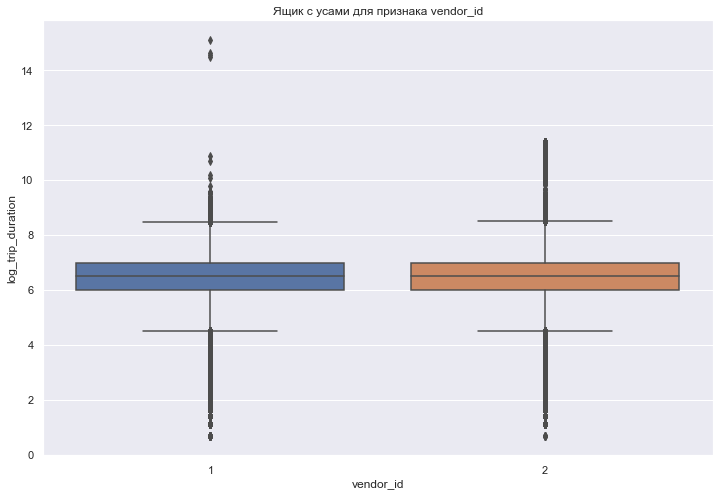

In [508]:
plt.figure(figsize=(12,8))
plt.title('Ящик с усами для признака vendor_id')
sns.boxplot(x=df['vendor_id'], y=df['log_trip_duration'], data=df);


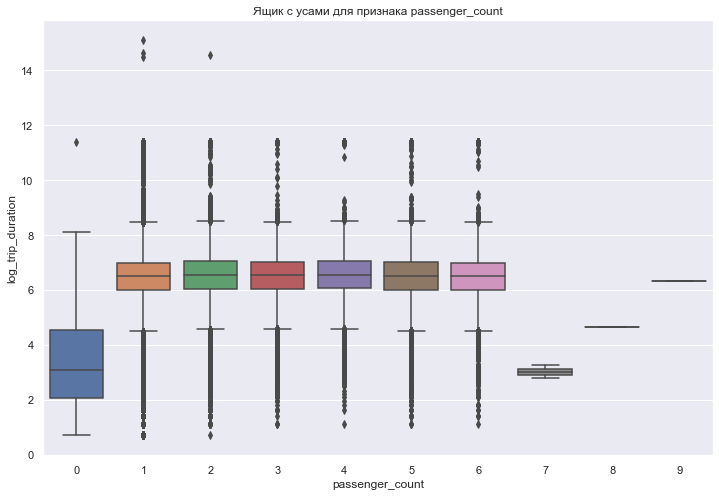

In [509]:
plt.figure(figsize=(12,8))
plt.title('Ящик с усами для признака passenger_count')
sns.boxplot(x=df['passenger_count'], y=df['log_trip_duration'], data=df);

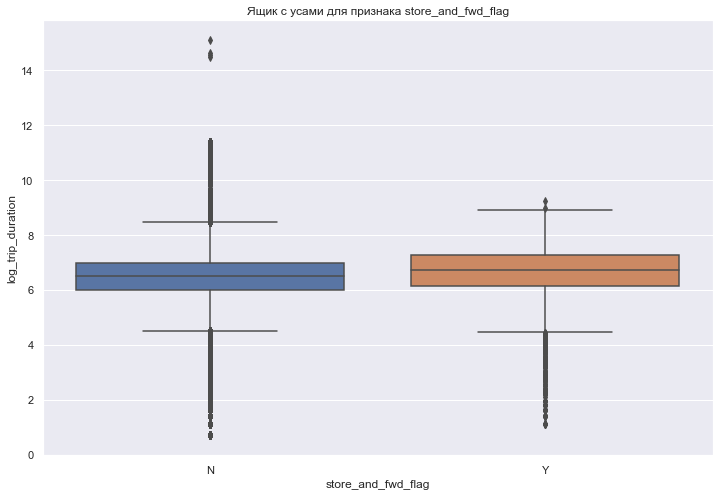

In [510]:
plt.figure(figsize=(12,8))
plt.title('Ящик с усами для признака store_and_fwd_flag')
sns.boxplot(x=df['store_and_fwd_flag'], y=df['log_trip_duration'], data=df);

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [511]:
df=pd.get_dummies(df, columns=["vendor_id", "store_and_fwd_flag"], drop_first=True)

In [512]:
df['vendor_id_2'] = df['vendor_id_2'].astype ('object')
df['store_and_fwd_flag_Y'] = df['store_and_fwd_flag_Y'].astype ('object')


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [520]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

y = df["log_trip_duration"]
X = df.drop(['log_trip_duration','id', 'distance_haversine', 'trip_duration'], axis=1) 
df['tr_jams'] = df['tr_jams'].astype ('object')
df['free_roads'] = df['free_roads'].astype ('object')
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
numeric_features = [ "passenger_count" ] 
categorical = list(x_train.dtypes[x_train.dtypes == "object"].index)
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
print("Test rmsle = %.4f" % rmsle(y_test, y_pred))
print("Train rmsle = %.4f" % rmsle(y_train, y_train_pred))

Test rmsle = 0.7853
Train rmsle = 0.7882


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

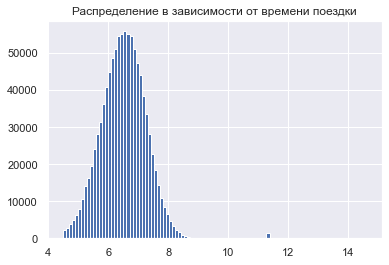

In [532]:
#под обучающей подразумевался y_train?
quantile_time = y_train['log_trip_duration'].quantile(0.01)
filtered_time = y_train[y_train['log_trip_duration']>quantile_time]
plt.title('Распределение в зависимости от времени поездки')
plt.hist((filtered_time.log_trip_duration), bins = 100)
plt.show()


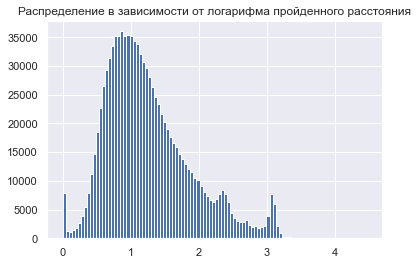

In [535]:
quantile_hav = x_train['log_haversine'].quantile(0.99)
filtered_hav = x_train[x_train['log_haversine']<quantile_time]
plt.title('Распределение в зависимости от логарифма пройденного расстояния')
plt.hist((filtered_hav.log_haversine), bins = 100)
plt.show()


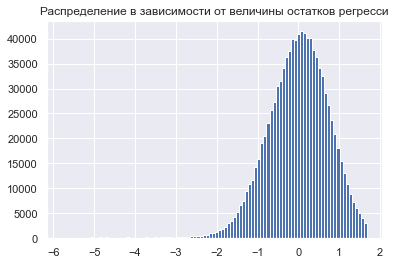

In [544]:
difference = (y_train - y_train_pred).to_frame()
quantile_res = difference['log_trip_duration'].quantile(0.99)
filtered_res = difference[difference['log_trip_duration']<quantile_res]
plt.title('Распределение в зависимости от величины остатков регресси')
plt.hist((filtered_res.log_trip_duration), bins = 100)
plt.show()


Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [539]:
from sklearn.linear_model import Lasso #чуть-чуть улучшилось, так как лассо как раз занулил ненужные признаки
y = df["log_trip_duration"]
X = df.drop(['log_trip_duration','id', 'distance_haversine', 'trip_duration'], axis=1) 
df['tr_jams'] = df['tr_jams'].astype ('object')
df['free_roads'] = df['free_roads'].astype ('object')
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
numeric_features = [ "passenger_count" ] 
categorical = list(x_train.dtypes[x_train.dtypes == "object"].index)
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
print("Test rmsle = %.4f" % rmsle(y_test, y_pred))
print("Train rmsle = %.4f" % rmsle(y_train, y_train_pred))

Test rmsle = 0.7935
Train rmsle = 0.7967


Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [562]:
from sklearn.linear_model import Lasso 
y = df["log_trip_duration"]
X = df.drop(['log_trip_duration','id', 'distance_haversine', 'trip_duration'], axis=1) 
df['tr_jams'] = df['tr_jams'].astype ('object')
df['free_roads'] = df['free_roads'].astype ('object')
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
numeric_features = [ "passenger_count" ] 
categorical = list(x_train.dtypes[x_train.dtypes == "object"].index)

Best alpha = 0.0100


Text(0, 0.5, 'CV score')

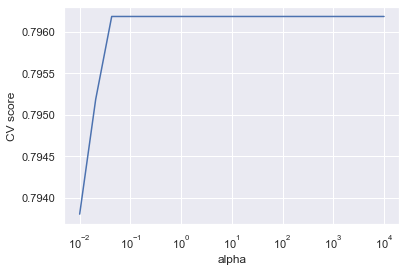

In [573]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=4, n_jobs=-1)
searcher.fit(x_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [576]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSlE = %.4f" % rmsle(y_test, y_pred))

Test RMSlE = 0.7917


Best alpha = 263.6651


Text(0, 0.5, 'CV score')

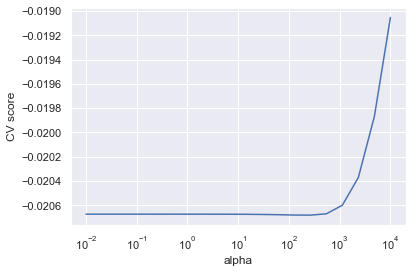

In [577]:
ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(ridge_pipeline, [{"regression__alpha": alphas}],
                         cv=4, n_jobs=-1)
searcher.fit(x_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [578]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha))
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSlE = %.4f" % rmsle(y_test, y_pred))

Test RMSlE = 0.7857


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

а можно будет после обоих дедлайнов попросить у кого-нибудь кодик этих трансформеров с разбивкой карты по сетке? сильно хочется поглядеть

![](кот_я.jpg)